In [208]:
# Add Matplotlib inline magic command
%matplotlib inline
# Dependencies and Setup
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

#Formatting describe()
pd.options.display.float_format = '{:,.2f}'.format

In [209]:
# Load cleaned_movies into DataFrame
movies_df = pd.read_csv('movies_final.csv')
#movies_df.head()

In [210]:
# Drop Unnamed column
movies_df = movies_df.loc[:,~movies_df.columns.str.contains('^Unnamed')]
#movies_df.describe()

# Functions

### Recommended: Column Count Descriptive Stats

In [211]:
#Obtain column value descriptive stats to determine count parameters
#Insert 1. 'column' in quotes 2. minimum quantile of dataframe to include
def count_cutoff(column, min):
    print(f"Top {min*100: .1f}% of {column} appearances in the movie dataframe")
    cutoff_df = movies_df[movies_df[column].map(movies_df[column].value_counts()) \
                    >= movies_df[column].value_counts().quantile(min)][column].value_counts()
    print(cutoff_df)
    print("\nSum and Percent Total of Dataframe")
    print(cutoff_df.sum())
    print(cutoff_df.sum() / 7412 * 100)
    print(f"\nAll {column} Count Descriptive Stats and Boxplot")
    print(movies_df[column].value_counts().describe())
    movies_df[column].value_counts().to_frame().boxplot(vert=False)
    plt.show()

## Dataframe Adjustments by Column Count
Recommend Using count_cutoff first to determine min/max

### Adjust Category Count Range by Raw Count

In [212]:
#Categorical variable reduction by value_count.  Uses movies_df dataframe  
#Insert 1. 'column' in quotes 2. minimum movie apperances (inclusive) 3. maximum movie apperances (inclusive)
#Returns a dataframe
def reduce_rawCount_df(column, min, max):
    df = movies_df[movies_df[column].map(movies_df[column].value_counts()) >= min]
    df = df[df[column].map(df[column].value_counts()) <= max]
    return df

### Adjust Category Count Range by Quantile

In [213]:
#Categorical variable reduction by value_count.  Uses movies_df dataframe  
#Insert 1. 'column' in quotes 2. minimum movie apperances by quantile (inclusive) 3. maximum movie apperances by quantile (inclusive)
#Returns a dataframe
def reduce_quantileCount_df(column, min, max):
    df = movies_df[movies_df[column].map(movies_df[column].value_counts()) >= movies_df['genre'].value_counts().quantile(min)]
    df = df[df[column].map(df[column].value_counts()) <= movies_df['genre'].value_counts().quantile(max)]
    return df

## Dataframe Adjustment by Category Score

### Adjust Median Category Score Range by Quantile

In [224]:
# #Categorical variable reduction by median_rating.  Uses movies_df dataframe  
# #Insert 1. 'column' in quotes 2. minimum movie apperances (inclusive) 3. maximum movie apperances (inclusive)
# #Returns a dataframe
# def reduce_df_median(column, min, max):
#     column_medians = movies_df.groupby([column]).median()['score']
#     df = movies_df[movies_df[column].map(movies_df.groupby([column]).median()['score']) >= column_medians.quantile(min)]
#     df = df[df[column].map(df[column].value_counts()) <= column_medians.quantile(max)]
#     return df

In [257]:
#Categorical variable reduction by median_rating.  Uses movies_df dataframe  
#Insert 1. 'column' in quotes 2. minimum movie apperances (inclusive) 3. maximum movie apperances (inclusive)
#Returns a dataframe
def reduce_median_df(df, column, min, max):
    column_medians = df.groupby([column]).median()['score']
    new_df = df[df[column].map(df.groupby([column]).median()['score']) >= column_medians.quantile(min)]
    new_df2 = new_df[new_df[column].map(new_df.groupby([column]).median()['score']) <= column_medians.quantile(max)]
    return new_df2

## Descriptive Statistics Analysis

### Categorical Ordered by Count

In [215]:
#insert dataframe and 'column' in quote
def cat_count(df, column):   
    #Column values and column value counts
    column_counts = df[column].value_counts()
    #Put column counts in a dataframe
    column_counts_df = pd.DataFrame(column_counts).rename(columns={column: "Count"})
    #Put the values in a list
    column_values_list = column_counts.index.to_list()
    
    #Get scores by column value
    value_scores = []
    for value in column_values_list:
        value_df = df.loc[df[column] == value]
        value_score = value_df['score'].to_list()
        value_scores.append(value_score)
    
    #Bargraph of column counts
    length = len(column_values_list)
    width = column_counts_df['Count'].max()
    column_bar = column_counts_df.plot.barh(figsize = (15, length * .5))
    column_bar.set_title(f"Number of Movies by {column}",fontsize=20)
    column_bar.set_xlabel("Count",fontsize=14)
    column_bar.set_ylabel(f"{column}",fontsize=14) 
    column_bar.legend(loc = 'lower right')
    plt.gca().invert_yaxis()

    #Add counts to bar graph
    for i, v in enumerate(column_counts):
        column_bar.text(v , i , str(v),
            color = 'black', fontweight = 'bold')
    
    plt.show()
    
    #Box plot for values and and value scores
    y_labels = column_values_list
    x_values = value_scores
    fig, ax = plt.subplots(figsize=(10, length * .3 ))
    ax.set_title(f'Score by {column}', fontsize=20)
    ax.set_xlabel("Scores", fontsize=14)
    ax.set_ylabel(column, fontsize=14)
    ax.boxplot(x_values, labels=y_labels, vert=False)
    plt.gca().invert_yaxis()
    ax.grid()
    # Save the figure.

    plt.show()

    print(f'All {column} Scores Descriptive Statistics')
    print(movies_df.groupby([column]).mean()['score'].describe())

### Categorical Ordered by Median Score

In [250]:
#insert dataframe and 'column' in quote
def cat_median(df, column):   
    #Column values and column value counts
    column_counts = df[column].value_counts()
    #Put column counts in a dataframe
    column_counts_df = pd.DataFrame(column_counts).rename(columns={column: "Count"})
    column_counts_df = column_counts_df.reset_index()
    #Get Medians
    median_df = df.groupby([column]).median()[['score']]

    #Merge
    merged_df = column_counts_df.merge(median_df, left_on='index', right_on=f'{column}')
    sorted_df = merged_df.sort_values(by='score')
    final_df = sorted_df.set_index('index')

    #Put the values in a list
    column_values_list = final_df.index.to_list()

    #Get scores by column value
    value_scores = []
    for value in column_values_list:
        value_df = df.loc[df[column] == value]
        value_score = value_df['score'].to_list()
        value_scores.append(value_score)

    #Bargraph of column counts
    width = 15
    maximum = column_counts_df['Count'].max()
    if maximum < 15:
        width = maximum
    length = len(column_values_list)
    
    length = len(column_values_list)
    column_bar = final_df[['Count']].plot.barh(figsize = (width * .5, length * .5))
    column_bar.set_title(f"Number of Movies by {column}",fontsize=20)
    column_bar.set_xlabel("Count",fontsize=14)
    column_bar.set_ylabel(f"{column}",fontsize=14) 
    column_bar.legend(loc = 'lower right')

    #Add counts to bar graph
    for i, v in enumerate(sorted_df['Count']):
        column_bar.text(v , i , str(v),
            color = 'black', fontweight = 'bold')

    plt.show()

    #Box plot for values and and value scores
    y_labels = column_values_list
    x_values = value_scores
    fig, ax = plt.subplots(figsize=(10, length * .3 ))
    ax.set_title(f'Score by {column}', fontsize=20)
    ax.set_xlabel("Scores", fontsize=14)
    ax.set_ylabel(column, fontsize=14)
    ax.boxplot(x_values, labels=y_labels, vert=False)
    ax.grid()
    # Save the figure.

    plt.show()

    print(f'All {column} Scores Descriptive Statistics')
    print(movies_df.groupby([column]).mean()['score'].describe())

In [ ]:
if sorted_df['Count'].max < 15
    width = sorted_df['Count'].max

### Numeric Ordered by Median

In [282]:
#insert 1. dataframe 2. 'column' in quotes 3/4. min/max display quantile in decimals (ex: .xx) 
def num_desc(df, column, x_min, x_max):
    
    # Create a box-and-whisker plot for the urban cities ride count.
    fig, ax = plt.subplots()
    ax.boxplot(movies_df[column], labels=[""],vert=False)
    # Add the title, y-axis label and grid.
    ax.set_title(column, fontsize=20)
    ax.set_xlabel('Score')
    ax.set_xlim(df[column].quantile(x_min), df[column].quantile(x_max))
    
    ax.grid()
    plt.show()
    
    # Plot actual vs. predicted rating
    fig, ax = plt.subplots(figsize=(10, 13))
    ax.scatter(df[column], df['score'],)
    ax.set_xlim(df[column].quantile(x_min), df[column].quantile(x_max))
    plt.title(f'{column} versus Score',fontsize=20)
    ax.set_xlabel(column, fontsize=14)
    ax.set_ylabel('Scores', fontsize=14)

    ax.grid()
    plt.show()
    
    print(f'All {column} Scores Descriptive Statistics')
    print(df[column].describe())

# Summary of Functions

In [ ]:
#Obtain column value descriptive stats to determine count parameters
#Insert 1. 'column' in quotes 2. minimum quantile of dataframe to include
#count_cutoff(column, min_quantile)

### DataFrame Adjustments

In [50]:
##Adjustments by Count
#count_df =  reduce_rawCount_df('column', min_count, max_count)
#count_df = reduce_quantileCount_df('column', count_quantile_min, count__quantile_max)

#Adjustments by Category Median Score
#median_df = reduce_median_df('column', quantile_min, quantile_max)

### Descriptive Stats

In [42]:
#Ordered by 1.Categorical Count 2. Categorical Median 3. Numeric Median
###NOTE: Numeric variables are not naturally binned and so are not described by count
#1. cat_count(df, 'column')
#2. cat_median(df, 'column')
#3. num_desc(df, 'column', percentile_min, percentile_max)

### Variables

In [43]:
##Categorical
# rating
# genre
# year
# director
# writer
# star
# country
# company

##Numeric
# votes
# gross
# runtime

# Analysis

### Score (for context)

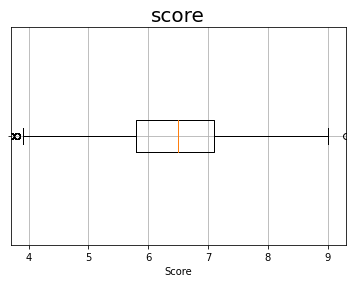

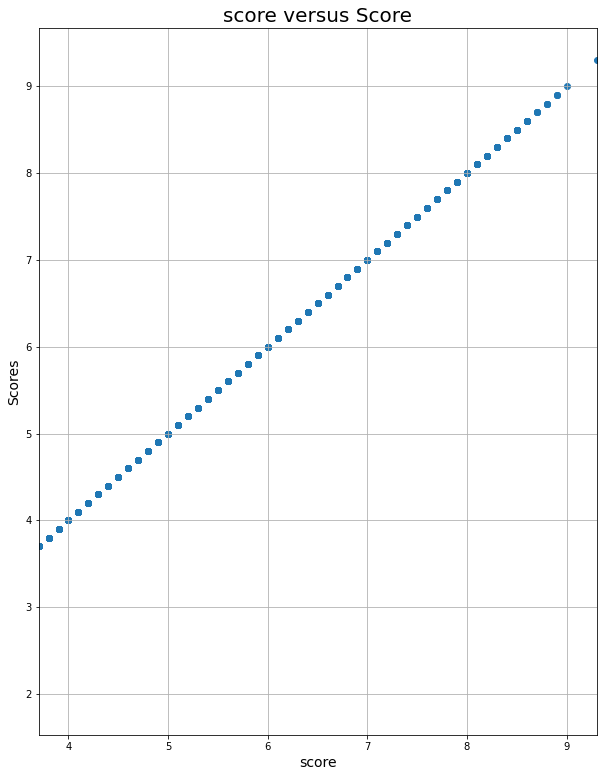

All score Scores Descriptive Statistics
count   7,412.00
mean        6.40
std         0.96
min         1.90
25%         5.80
50%         6.50
75%         7.10
max         9.30
Name: score, dtype: float64


In [290]:
num_desc(movies_df, 'score', .01, 1)

### Company

Top  92.0% of company appearances in the movie dataframe
Universal Pictures               376
Warner Bros.                     332
Columbia Pictures                332
Paramount Pictures               319
Twentieth Century Fox            240
                                ... 
Palace Pictures                    5
Vision PDG                         5
Weintraub Entertainment Group      5
Alive Films                        5
Bona Film Group                    5
Name: company, Length: 200, dtype: int64

Sum and Percent Total of Dataframe
4672
63.03291958985429

All company Count Descriptive Stats and Boxplot
count   2,242.00
mean        3.31
std        17.10
min         1.00
25%         1.00
50%         1.00
75%         2.00
max       376.00
Name: company, dtype: float64


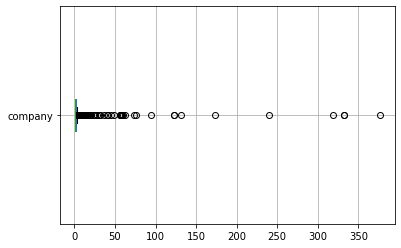

In [253]:
count_cutoff("company", .92)

In [270]:
company_df =  reduce_rawCount_df('company', 5, 9999)
company_df = reduce_median_df(company_df, 'company', .975, 1)

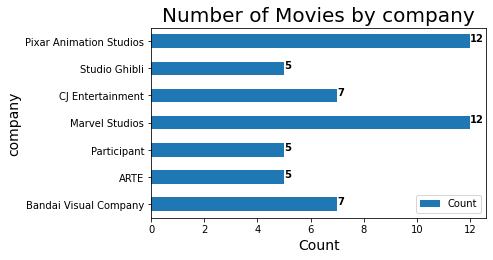

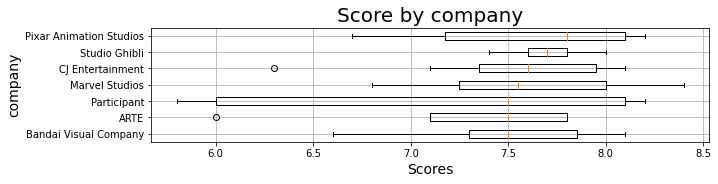

All company Scores Descriptive Statistics
count   2,242.00
mean        6.43
std         0.95
min         1.90
25%         5.90
50%         6.50
75%         7.10
max         8.60
Name: score, dtype: float64


In [271]:
cat_median(company_df2, 'company')

### Actor

Top  87.0% of star appearances in the movie dataframe
Nicolas Cage         43
Robert De Niro       41
Tom Hanks            41
Denzel Washington    37
Bruce Willis         34
                     ..
Bill Pullman          5
Cillian Murphy        5
Treat Williams        5
Frances McDormand     5
Kevin Hart            5
Name: star, Length: 368, dtype: int64

Sum and Percent Total of Dataframe
4076
54.99190501888829

All star Count Descriptive Stats and Boxplot
count   2,652.00
mean        2.79
std         4.30
min         1.00
25%         1.00
50%         1.00
75%         2.00
max        43.00
Name: star, dtype: float64


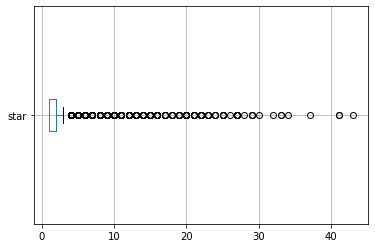

In [269]:
count_cutoff("star", .87)

In [278]:
reduce_rawCount_df('star', 5, 999)['score'].describe()

count   4,076.00
mean        6.46
std         0.85
min         1.90
25%         5.90
50%         6.50
75%         7.00
max         9.30
Name: score, dtype: float64

In [279]:
reduce_rawCount_df('star', 0, 4)['score'].describe()

count   3,336.00
mean        6.32
std         1.08
min         1.90
25%         5.70
50%         6.40
75%         7.10
max         8.70
Name: score, dtype: float64